In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras 
import tensorflow as tf 

In [2]:
from datetime import datetime, timezone
from dateutil import parser
from nba_api.live.nba.endpoints import scoreboard
from nba_api.live.nba.endpoints import boxscore
from nba_api.stats.endpoints import leaguegamefinder


#nba = pd.DataFrame.from_dict(scoreboard.ScoreBoard().games.get_dict())
#nba.head(10)

seasons = ['2023-24', '2024-25', '2025-26']
allgamedata = []

for season in seasons:
    games = leaguegamefinder.LeagueGameFinder(season_nullable=season)
    games_df = games.get_data_frames()[0]
    allgamedata.append(games_df)
if allgamedata:
    combinedgames_df = pd.concat(allgamedata, ignore_index=True)
    filteredgames_df = combinedgames_df[combinedgames_df['GAME_ID'].astype(str).str.startswith(('002', '004'))]
else:
    print("No data retrieved.")
#combinedgames_df.head()


In [3]:
from sklearn.preprocessing import LabelEncoder

data = filteredgames_df.copy()
completegames =data.dropna(subset='WL')
uniquegames = completegames[['GAME_ID']].drop_duplicates()
game_id_list = uniquegames['GAME_ID'].tolist()
# df = pd.DataFrame(game_id_list, columns=["GAME_ID"])
# df.to_csv('game_id.csv', index=False)


In [4]:
alldata = []

for game in game_id_list:
    #print(game)
    box = boxscore.BoxScore(game)
    boxdict = box.game.get_dict()

    arenaname = box.arena.get_dict()['arenaName']
    officialnames = [box.officials.get_dict()[i].get('name') for i in range(3)]
    hometeam = box.home_team.get_dict()['teamName']
    awayteam = box.away_team.get_dict()['teamName']

    desiredstats = ['assists', 'points', 'reboundsTotal', 'turnovers']
    homestats = [box.home_team_stats.get_dict()['statistics'].get(column) for column in desiredstats]
    awaystats = [box.away_team_stats.get_dict()['statistics'].get(column) for column in desiredstats]

    gamedata = [arenaname] + officialnames + [hometeam] + homestats + [awayteam] + awaystats
    alldata.append(gamedata)

#print(alldata)   
    
#if alldata:
#    alldata_df = pd.concat(alldata, ignore_index=True)
#else: 
#    print('No data retrieved')
    
# desiredcolumns = ['arena', 'officials', 'homeTeam', 'awayTeam']
# extracted = [boxdict.get(column) for column in desiredcolumns]


In [5]:
fincolumn = ['arenaName', 'official1', 'official2', 'official3', 
           'homeTeam', 'homeassists', 'homepoints', 'homereb', 'homeTO', 
           'awayTeam', 'awayassists', 'awaypoints', 'awayreb', 'awayTO']
if alldata:
    df = pd.DataFrame(alldata, columns=fincolumn)
else: 
    print('No data retrieved')

In [6]:
import gc

#df.to_csv('findata.csv')
del alldata, allgamedata, combinedgames_df, completegames, data, filteredgames_df, game_id_list, games_df, uniquegames
gc.collect()


0

In [7]:
data_encoded = df.copy()

label_encoders = {}
textcol = ['arenaName', 'official1', 'official2', 'official3', 
           'homeTeam', 'awayTeam']

for col in textcol:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
    label_encoders[col] = le

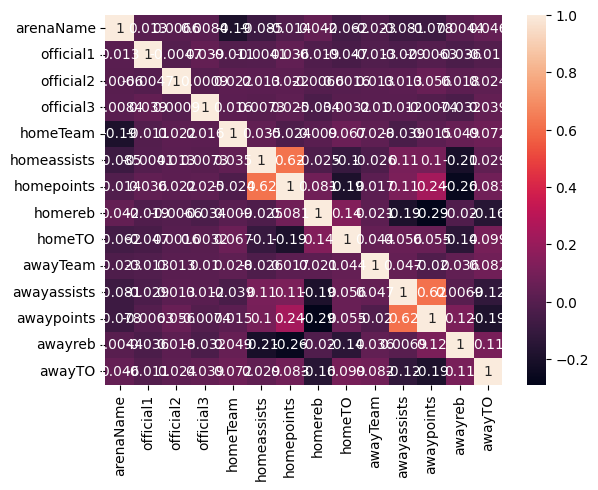

In [8]:
sns.heatmap(data_encoded.corr(), annot=True)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

feature_cols = ['arenaName', 'official1', 'official2', 'official3', 
           'homeTeam', 'homeassists', 'homereb', 'homeTO', 
           'awayTeam', 'awayassists', 'awayreb', 'awayTO']

x = data_encoded[feature_cols]
yH = data_encoded['homepoints']
yA = data_encoded['awaypoints']

x_train, x_test, yH_train, yH_test, yA_train, yA_test = train_test_split(x, yH, yA, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [11]:
modelH = keras.Sequential([
    keras.layers.Input( shape=(x_train_scaled.shape[1],)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(216, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

huber_loss = tf.keras.losses.Huber(delta=1.0)
modelH.compile(optimizer='adam', loss=huber_loss)

modelA = keras.Sequential([
    keras.layers.Input( shape=(x_train_scaled.shape[1],)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(216, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

huber_loss = tf.keras.losses.Huber(delta=1.0)
modelA.compile(optimizer='adam', loss=huber_loss)

In [ ]:
print("hello")

In [12]:
modelH.fit(x_train_scaled, yH_train, epochs=10, batch_size=64, validation_data=(x_test_scaled, yH_test))
modelA.fit(x_train_scaled, yA_train, epochs=10, batch_size=64, validation_data=(x_test_scaled, yA_test))

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 98.1438 - val_loss: 51.0352
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.4487 - val_loss: 13.1217
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13.2412 - val_loss: 12.4033
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.1249 - val_loss: 11.0202
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 10.8257 - val_loss: 9.9598
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.5768 - val_loss: 8.8900
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.6275 - val_loss: 8.6770
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.1518 - val_loss: 8.1398
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.8777 - val_loss: 7.9044
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5748 - val_loss: 7.8649
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 98.4586 - val_loss: 57.8046
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

<Axes: >

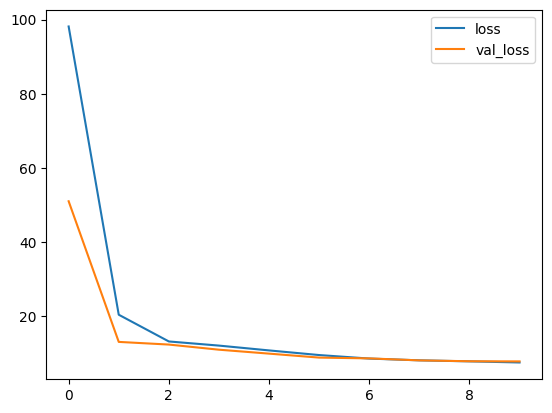

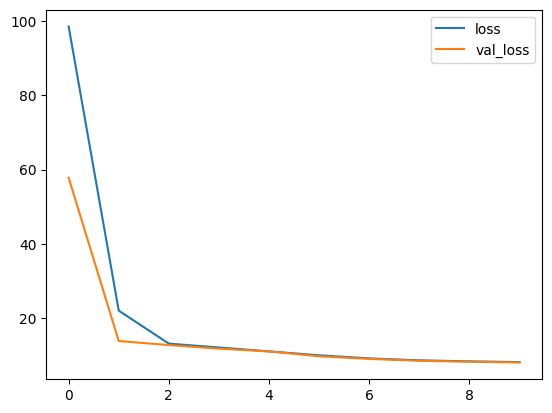

In [13]:
modelH_losses = pd.DataFrame(modelH.history.history)
modelH_losses.plot()
modelA_losses = pd.DataFrame(modelA.history.history)
modelA_losses.plot()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictionsH = modelH.predict(x_test_scaled)
mean_absolute_error(yH_test, predictionsH)
predictionsA = modelA.predict(x_test_scaled)
mean_absolute_error(yA_test, predictionsA)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


8.618951797485352

In [67]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import BoxScoreSummaryV3

warnings.filterwarnings("ignore")

board = scoreboard.ScoreBoard()
date = board.score_board_date
todaysgames = board.games.get_dict()

nbateams = teams.get_teams()

tgamearr = []
f = "{gameId}: {awayTeam} vs. {homeTeam}"

for tgame in todaysgames:
    x = f.format(gameId= tgame['gameId'], 
                 awayTeam= tgame['awayTeam']['teamName'], 
                 homeTeam=tgame['homeTeam']['teamName'])
    tgamearr.append(x)

selectedgame = widgets.Dropdown(options= tgamearr, 
                                description= 'Select Game:')
selectedgame.style = {'description_width': 'initial'}

predictbutton = widgets.Button(description="Predict Score")

output = widgets.Output()

#summary = BoxScoreSummaryV3('0022500381')
#v3data = summary.game_summary.get_dict()
#print(v3data)


#summary.arena_info.get_dict()['data'][0][2] #arenaName
#summary.officials.get_dict()['data'][0] #officials
#summary.game_summary.get_dict()['data'][0][8] home team id
#summary.game_summary.get_dict()['data'][0][7] away team id

def predictScore(b):
    with output:
        clear_output()
        
        gamecode = selectedgame.value
        res = gamecode.split(':')
        #gamescore = boxscore.BoxScore(res[0])
        summary = BoxScoreSummaryV3(game_id=res[0])
        v3arena = summary.arena_info.get_dict()
        v3off = summary.officials.get_dict()
        v3sum = summary.game_summary.get_dict()
        
        Iarena = v3arena['data'][0][2]
        Iofficials = [v3off['data'][i][2] for i in range(3)]
        HTeamID = v3sum['data'][0][9]
        ATeamID = v3sum['data'][0][8]
        Ihome = [team for team in nbateams if team['id'] == HTeamID][0]['nickname']
        Iaway = [team for team in nbateams if team['id'] == ATeamID][0]['nickname']
        
        #Iarena = gamescore.arena.get_dict()['arenaName']
        #Iofficials = [gamescore.officials.get_dict()[i].get('name') for i in range(3)]
        #Ihome = gamescore.home_team.get_dict()['teamName']
        #Iaway = gamescore.away_team.get_dict()['teamName']
        #HTeamID = [team for team in nbateams if team["nickname"] == Ihome][0]['id']
        #ATeamID = [team for team in nbateams if team["nickname"] == Iaway][0]['id']
        
        Hlog = teamgamelog.TeamGameLog(team_id=HTeamID)
        Alog = teamgamelog.TeamGameLog(team_id=ATeamID)
        Hdf = Hlog.get_data_frames()[0]
        Adf = Alog.get_data_frames()[0]
        avgrebH = Hdf['REB'].mean()
        avgastH = Hdf['AST'].mean()
        avgtovH = Hdf['TOV'].mean()
        avgrebA = Adf['REB'].mean()
        avgastA = Adf['AST'].mean()
        avgtovA = Adf['TOV'].mean()
        
        input_features = [
            label_encoders['arenaName'].transform([Iarena])[0],
            label_encoders['official1'].transform([Iofficials[0]])[0],
            label_encoders['official2'].transform([Iofficials[1]])[0],
            label_encoders['official3'].transform([Iofficials[2]])[0],
            label_encoders['homeTeam'].transform([Ihome])[0], 
            avgastH, avgrebH, avgtovH, 
            label_encoders['awayTeam'].transform([Iaway])[0], 
            avgastA, avgrebA, avgtovA]
        
        input_array = np.array(input_features).reshape(1,-1)
        input_array = scaler.transform(input_array)
        predictedHscore = modelH.predict(input_array)
        predictedAscore = modelA.predict(input_array)
        
        print(f"Predicted Score: {str(Iaway)} {int(predictedAscore[0])} - {str(Ihome)} {int(predictedHscore[0])}")

predictbutton.on_click(predictScore)
display(date, selectedgame, predictbutton, output)

'2025-12-19'

Dropdown(description='Select Game:', options=('0022500381: Heat vs. Celtics', '0022500382: 76ers vs. Knicks', …

Button(description='Predict Score', style=ButtonStyle())

Output()